In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score 
from sklearn.feature_extraction.text import TfidfVectorizer

# Creación de Features Categóricas

### Categórica 1: País del usuario
Agrego paises calculados en la visualización 3 del notebook 01

In [17]:
import json

DATA_DIR = Path('../data/nlp-getting-started')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'
LOCATION_TO_COUNTRY_PATH = Path('../data/location_to_country.json')
RANDOM_SEED = 27

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

with open(LOCATION_TO_COUNTRY_PATH, 'r', encoding='utf-8') as f:
    location_to_country = json.load(f)

train_df['country'] = train_df['location'].map(location_to_country)
test_df['country'] = test_df['location'].map(location_to_country)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nCountries in train: {train_df['country'].notna().sum()}/{len(train_df)}")
print(f"Countries in test: {test_df['country'].notna().sum()}/{len(test_df)}")
train_df.head()

Train shape: (7613, 6)
Test shape: (3263, 5)

Countries in train: 4060/7613
Countries in test: 882/3263


,id,keyword,location,text,target,country
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN


Claro, es genial poder clasificar los que tienen location. Pero bueno, vemos acá que del test solo 882 tienen country. Nos sirve para alguna decisión de un arbol ponele, pero es limitado...

### Categórica 2: Has_Url
Vimos en la visu 5 que había fuerte diferencia en la proporción de tweets con url entre clases.

In [18]:
train_df['has_url'] = train_df['text'].fillna('').str.contains(r'http[s]?://', regex=True).astype(str)
test_df['has_url'] = test_df['text'].fillna('').str.contains(r'http[s]?://', regex=True).astype(str)

print("has_url distribution in train:")
print(train_df['has_url'].value_counts())
print(f"\nPercentage with URL: {train_df['has_url'].eq('True').mean()*100:.1f}%")

print("\nhas_url distribution in test:")
print(test_df['has_url'].value_counts())
print(f"\nPercentage with URL: {test_df['has_url'].eq('True').mean()*100:.1f}%")

categorical_features = ['country', 'has_url']

has_url distribution in train:
has_url
True     3971
False    3642
Name: count, dtype: int64

Percentage with URL: 52.2%

has_url distribution in test:
has_url
True     1731
False    1532
Name: count, dtype: int64

Percentage with URL: 53.0%


# Features numéricas

### Numérica 1: text_length

La visu 4 mostró que la longitud del tweet es un indicador levemente útil, puede aportar algo.

In [19]:
train_df['text_length'] = train_df['text'].fillna('').str.len()
test_df['text_length'] = test_df['text'].fillna('').str.len()

print("Text length stats:")
print(f"Train - mean: {train_df['text_length'].mean():.1f}, std: {train_df['text_length'].std():.1f}")
print(f"Test - mean: {test_df['text_length'].mean():.1f}, std: {test_df['text_length'].std():.1f}")

numeric_features = ['text_length']
categorical_features = ['country', 'has_url']
embedding_feature = 'text'

Text length stats:
Train - mean: 101.0, std: 33.8
Test - mean: 102.1, std: 34.0


### Numérica 2: sentiment_score
Usé VADER para calcular un score de sentimiento del texto del tweet. La idea es que tweets con sentimientos muy marcados (positivos o negativos) pueden ser más probables de ser reales, mientras que los neutrales pueden ser más sospechosos.

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if pd.isna(text) or text.strip() == '':
        return 0.5
    compound = analyzer.polarity_scores(text)['compound']
    return (compound + 1) / 2

train_df['sentiment_score'] = train_df['text'].apply(get_sentiment)
test_df['sentiment_score'] = test_df['text'].apply(get_sentiment)

print("Sentiment score stats:")
print(f"Train - mean: {train_df['sentiment_score'].mean():.3f}, std: {train_df['sentiment_score'].std():.3f}")
print(f"Test - mean: {test_df['sentiment_score'].mean():.3f}, std: {test_df['sentiment_score'].std():.3f}")

print("\nSentiment score distribution in train:")
print(train_df['sentiment_score'].describe())

numeric_features = ['text_length', 'sentiment_score']

Sentiment score stats:
Train - mean: 0.428, std: 0.232
Test - mean: 0.426, std: 0.229

Sentiment score distribution in train:
count    7613.000000
mean        0.427633
std         0.232416
min         0.005850
25%         0.228850
50%         0.500000
75%         0.538600
max         0.986500
Name: sentiment_score, dtype: float64


Bueno, en la visu se veía que había diferencias entre las distribuciones de sentimiento entre clases. Voy a usar esta feature en el modelo y ver cómo sale.

In [21]:
train_df.head(10)

,id,keyword,location,text,target,country,has_url,text_length,sentiment_score
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,False,69,0.63660
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,False,38,0.33000
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,False,133,0.35200
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,False,65,0.50000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,False,88,0.50000
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,NaN,False,110,0.33000
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,NaN,False,95,0.18755
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,NaN,False,59,0.42345
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,NaN,False,79,0.30910
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,NaN,False,52,0.50000


okey, aunque me gustan las categoricas que puse, pareciera que están medio subrepresentadas en el dataset (pocos con country por ejemplo). Más adelante voy a revisar si tuvo sentido esto y si conviene cambiar features.

## Model Training with GridSearchCV

Training logistic regression with hyperparameter search using F1 score.

In [22]:
from sklearn.model_selection import train_test_split, KFold
from scipy.sparse import hstack

# 1. Separar features y target
X = train_df[numeric_features + categorical_features + [embedding_feature]].copy()
y = train_df['target'].copy()

# 2. Split estratificado train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Target distribution in train: {y_train.value_counts().to_dict()}")
print(f"Target distribution in val: {y_val.value_counts().to_dict()}")


Train set: 6090 samples
Validation set: 1523 samples
Target distribution in train: {0: 3473, 1: 2617}
Target distribution in val: {0: 869, 1: 654}


In [23]:
# Transformer para numéricas
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_val_numeric = scaler.transform(X_val[numeric_features])
X_test_numeric = scaler.transform(test_df[numeric_features])

from sklearn.model_selection import KFold
from scipy.sparse import csr_matrix

# has_url -> OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

X_train_hasurl = ohe.fit_transform(
    X_train[['has_url']].fillna('missing')
)
X_val_hasurl = ohe.transform(
    X_val[['has_url']].fillna('missing')
)
X_test_hasurl = ohe.transform(
    test_df[['has_url']].fillna('missing')
)

print("\nOneHotEncoder (has_url):")
print(f"  categories: {ohe.categories_[0].tolist()}")



OneHotEncoder (has_url):
  categories: ['False', 'True']


In [24]:
# country -> Mean Target Encoding con K-Fold
country_col = 'country'
alpha = 10  # smoothing
global_mean = y_train.mean()

# aseguramos string y categoría "missing"
country_train = X_train[country_col].fillna('missing').astype(str)
country_val = X_val[country_col].fillna('missing').astype(str)
country_test = test_df[country_col].fillna('missing').astype(str)

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

country_train_enc = pd.Series(index=country_train.index, dtype=float)

for train_idx, holdout_idx in kfold.split(country_train):
    # folds internos para evitar leakage
    ct_train = country_train.iloc[train_idx]
    y_fold = y_train.iloc[train_idx]

    stats = (
        pd.DataFrame({'country': ct_train, 'target': y_fold})
        .groupby('country')['target']
        .agg(['mean', 'count'])
    )
    stats['smoothed'] = (
        stats['mean'] * stats['count'] + alpha * global_mean
    ) / (stats['count'] + alpha)

    enc_values = country_train.iloc[holdout_idx].map(stats['smoothed'])
    country_train_enc.iloc[holdout_idx] = enc_values

# categorías raras que no se mapearon en algún fold
country_train_enc = country_train_enc.fillna(global_mean)

# encoding para val/test: se calcula con TODO el train (ya no hay leakage)
full_stats = (
    pd.DataFrame({'country': country_train, 'target': y_train})
    .groupby('country')['target']
    .agg(['mean', 'count'])
)
full_stats['smoothed'] = (
    full_stats['mean'] * full_stats['count'] + alpha * global_mean
) / (full_stats['count'] + alpha)

country_val_enc = country_val.map(full_stats['smoothed']).fillna(global_mean)
country_test_enc = country_test.map(full_stats['smoothed']).fillna(global_mean)

print("\nMean encoding (country):")
print(f"  global_mean: {global_mean:.4f}")
print(f"  ejemplo valores train: {country_train_enc.head().to_dict()}")

# Pasar estos vectores a matrices sparse columna para combinarlos con hstack
X_train_country_enc = csr_matrix(country_train_enc.values.reshape(-1, 1))
X_val_country_enc   = csr_matrix(country_val_enc.values.reshape(-1, 1))
X_test_country_enc  = csr_matrix(country_test_enc.values.reshape(-1, 1))

# matriz categórica final = [has_url OHE, country_mean]
X_train_cat = hstack([X_train_hasurl, X_train_country_enc])
X_val_cat   = hstack([X_val_hasurl,   X_val_country_enc])
X_test_cat  = hstack([X_test_hasurl,  X_test_country_enc])



Mean encoding (country):
  global_mean: 0.4297
  ejemplo valores train: {2721: 0.4156582304978332, 2259: 0.4156582304978332, 1815: 0.3698482572290349, 682: 0.42014738135427787, 7216: 0.4282758387941799}


In [25]:

# Transformer para texto (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    lowercase=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english'
)
X_train_text = tfidf_vectorizer.fit_transform(X_train[embedding_feature].fillna(''))
X_val_text = tfidf_vectorizer.transform(X_val[embedding_feature].fillna(''))
X_test_text = tfidf_vectorizer.transform(test_df[embedding_feature].fillna(''))

print(f"\nTF-IDF vectorizer:")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"  Feature names (first 10): {tfidf_vectorizer.get_feature_names_out()[:10].tolist()}")


TF-IDF vectorizer:
  Vocabulary size: 5000
  Feature names (first 10): ['0', '00', '00 http', '00 pm', '000', '01', '01 04', '02', '03', '04']


In [26]:
# 4. Combinar todas las features
X_train_combined = hstack([X_train_numeric, X_train_cat, X_train_text])
X_val_combined = hstack([X_val_numeric, X_val_cat, X_val_text])
X_test_combined = hstack([X_test_numeric, X_test_cat, X_test_text])

print(f"\nCombined feature matrix:")
print(f"  Train shape: {X_train_combined.shape}")
print(f"  Validation shape: {X_val_combined.shape}")
print(f"  Test shape: {X_test_combined.shape}")


Combined feature matrix:
  Train shape: (6090, 5005)
  Validation shape: (1523, 5005)
  Test shape: (3263, 5005)


In [27]:
# 5. Grid Search para Logistic Regression
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 20],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced'],
    'max_iter': [500, 1000]
}

lr = LogisticRegression(random_state=RANDOM_SEED)

# GridSearchCV con F1 score
grid_search = GridSearchCV(
    lr,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print(f"\nStarting Grid Search with {len(param_grid['C']) * len(param_grid['solver']) * len(param_grid['class_weight']) * len(param_grid['max_iter'])} combinations...")
grid_search.fit(X_train_combined, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# 6. Evaluar en validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_combined)
val_f1 = f1_score(y_val, y_val_pred)

print(f"\n{'='*60}")
print(f"VALIDATION F1 SCORE: {val_f1:.4f}")
print(f"{'='*60}")

# Guardar todo para usar después
best_lr_model = best_model
preprocessors = {
    'scaler': scaler,
    'ohe': ohe,
    'tfidf': tfidf_vectorizer
}


Starting Grid Search with 56 combinations...
Fitting 5 folds for each of 56 candidates, totalling 280 fits

Best parameters: {'C': 2, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.7494

VALIDATION F1 SCORE: 0.7615


# Conteste las preguntas:

## ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

## Validation Evaluation

Detailed evaluation on the validation set including classification report and confusion matrix.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Clasificación completa
print(f"{'='*60}")
print(f"DETAILED VALIDATION EVALUATION")
print(f"{'='*60}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['No desastre (0)', 'Desastre (1)']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicho 0  Predicho 1")
print(f"Real 0 (no des)     {cm[0,0]:6d}      {cm[0,1]:6d}")
print(f"Real 1 (desastre)   {cm[1,0]:6d}      {cm[1,1]:6d}")

print(f"\n{'='*60}")
print(f"VALIDATION F1 SCORE: {val_f1:.4f}")
print(f"{'='*60}") 

DETAILED VALIDATION EVALUATION

Classification Report:
                 precision    recall  f1-score   support

No desastre (0)       0.82      0.82      0.82       869
   Desastre (1)       0.76      0.76      0.76       654

       accuracy                           0.80      1523
      macro avg       0.79      0.79      0.79      1523
   weighted avg       0.80      0.80      0.80      1523


Confusion Matrix:
                 Predicho 0  Predicho 1
Real 0 (no des)        713         156
Real 1 (desastre)      156         498

VALIDATION F1 SCORE: 0.7615


## ¿Cuáles son las features más importantes del modelo?

Total features: 5005

Top 30 features más importantes:
         feature  coefficient
2151   hiroshima     4.381057
1393  earthquake     3.749714
1695       fires     3.593341
846   california     3.147560
3039         new    -3.099545
4606     typhoon     3.022060
4878    wildfire     3.014689
800    buildings     2.932460
4504       train     2.884047
1365     drought     2.783504
1244  derailment     2.763645
715      bombing     2.751401
4198       storm     2.685133
901   casualties     2.684507
2823    massacre     2.638483
3026        near     2.574520
1739      floods     2.506987
1775      forest     2.504547
4473     tornado     2.457713
2695       lives     2.415352
1491  evacuation     2.401101
1536   explosion     2.381438
665         blew    -2.365847
1730       flood     2.265254
2877       mh370     2.242496
1120       crash     2.205623
2269   hurricane     2.203791
1488   evacuated     2.187893
2022   hailstorm     2.182553
520         bags    -2.178557


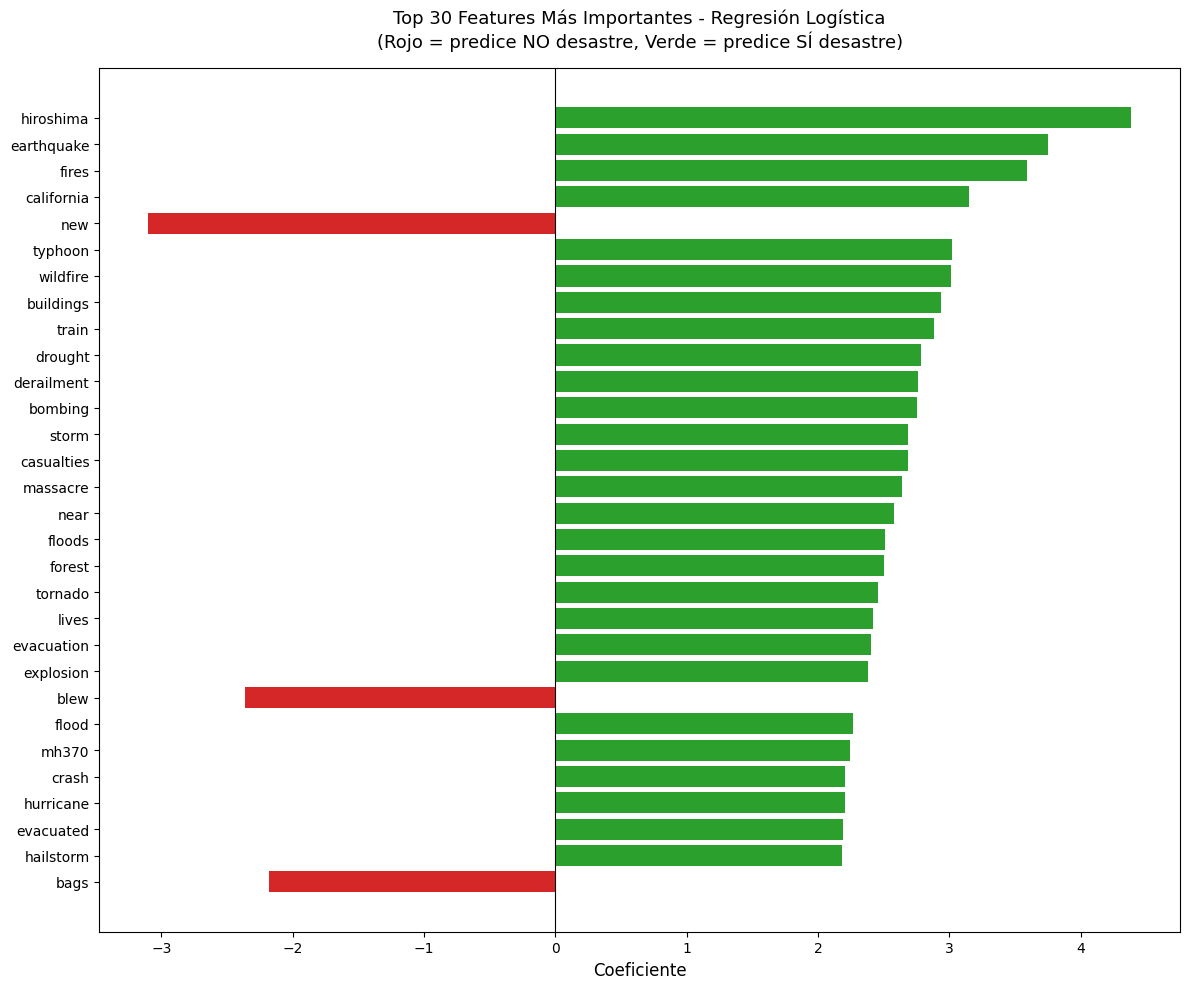

In [29]:
import matplotlib.pyplot as plt

# Obtener coeficientes del mejor modelo
coefficients = best_lr_model.coef_[0]

# Crear nombres de features
# Estructura: [numeric_features, has_url_False, has_url_True, country_encoded, tfidf_features]
feature_names = (
    numeric_features + 
    ['has_url_False', 'has_url_True', 'country_encoded'] +
    list(tfidf_vectorizer.get_feature_names_out())
)

# Crear DataFrame con features y coeficientes
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(f"Total features: {len(feature_names)}")
print(f"\nTop 30 features más importantes:")
print(feature_importance.head(30)[['feature', 'coefficient']].to_string())

# Graficar top 30
top_30 = feature_importance.head(30)

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#d62728' if c < 0 else '#2ca02c' for c in top_30['coefficient']]
ax.barh(range(len(top_30)), top_30['coefficient'], color=colors)
ax.set_yticks(range(len(top_30)))
ax.set_yticklabels(top_30['feature'], fontsize=10)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Coeficiente', fontsize=12)
ax.set_title('Top 30 Features Más Importantes - Regresión Logística\n(Rojo = predice NO desastre, Verde = predice SÍ desastre)', 
             fontsize=13, pad=15)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Al predecir con este modelo para la competencia, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

In [30]:
from pathlib import Path

# Crear directorio para submissions
submissions_dir = Path('../resultados')
submissions_dir.mkdir(parents=True, exist_ok=True)
baseline_submit_path = submissions_dir / 'logistic_regression_baseline.csv'

# Predecir en test set
y_test_pred = best_lr_model.predict(X_test_combined)

# Crear submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred
})

# Guardar CSV
submission.to_csv(baseline_submit_path, index=False)

print(f"{'='*60}")
print(f"PREDICCIONES PARA KAGGLE GENERADAS")
print(f"{'='*60}")
print(f"\nArchivo guardado en: {baseline_submit_path}")
print(f"Total predicciones: {len(submission)}")
print(f"\nDistribución de predicciones:")
print(submission['target'].value_counts().sort_index())
print(f"\nPrimeras 10 filas:")
print(submission.head(10))

PREDICCIONES PARA KAGGLE GENERADAS

Archivo guardado en: ../resultados/logistic_regression_baseline.csv
Total predicciones: 3263

Distribución de predicciones:
target
0    1935
1    1328
Name: count, dtype: int64

Primeras 10 filas:
   id  target
0   0       1
1   2       1
2   3       1
3   9       0
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0
